In [ ]:
import os
from IPython.display import display

from dotenv import load_dotenv

load_dotenv()

openrouter_api_key = os.getenv("OPENROUTER_API_KEY")

import gradio as gr

: 

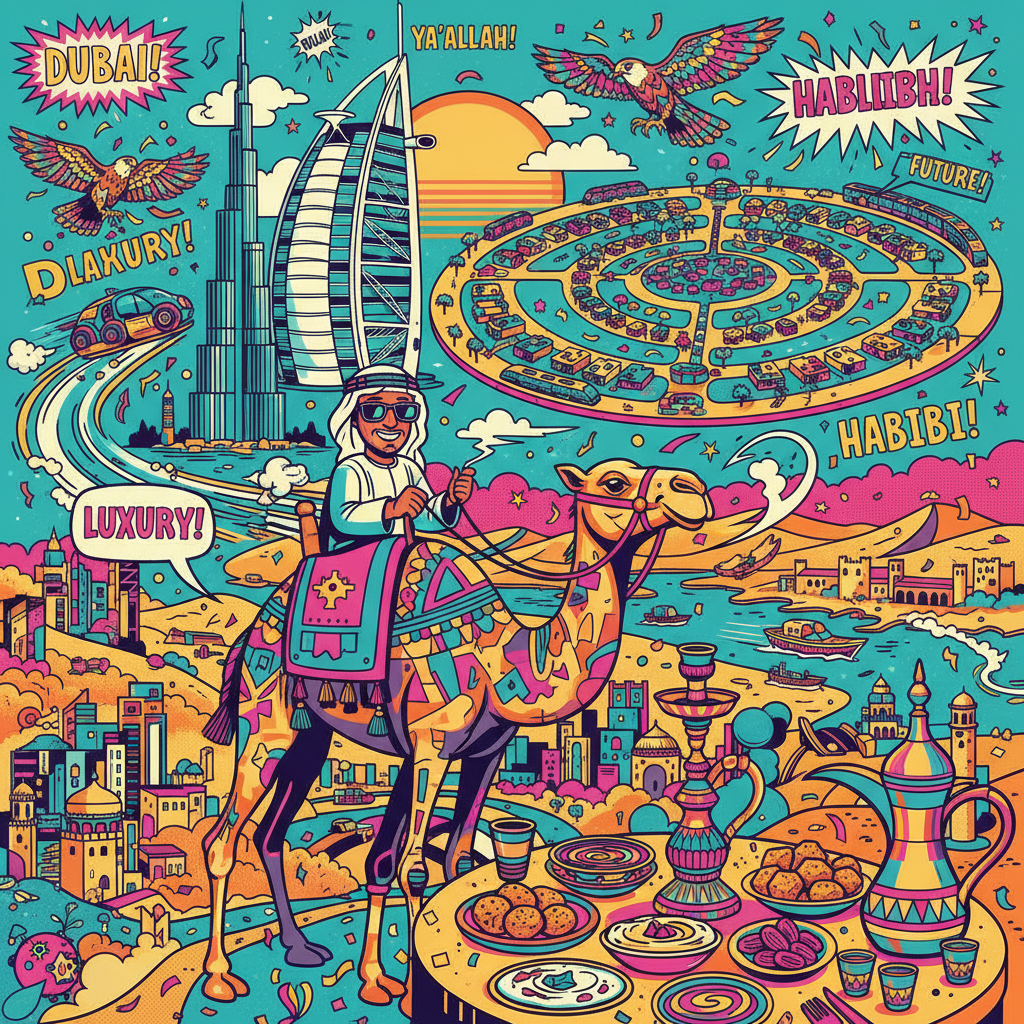

In [4]:
##An agent that takes in technical questions which may invove generating audio and video abd responds with explanation where nececessary
import os
import base64
from io import BytesIO
from PIL import Image
import requests

# Assuming you already have:
# openrouter_api_key = os.getenv('OPENROUTER_API_KEY')

def artist(city):
    # function that takes a city name and returns an image of the city
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {openrouter_api_key}",
        "Content-Type": "application/json",
        "HTTP-Referer": "http://localhost",  # Optional: helps with OpenRouter rankings
        "X-Title": "Artist App"
    }

    prompt_text = (
        f"Generate a vibrant pop-art style vacation scene in {city}, "
        f"showing famous tourist spots, landmarks, unique culture, food, "
        f"energy, and atmosphere of the city. Bold colors, high contrast, fun and dynamic composition."
    )

    payload = {
        "model": "google/gemini-2.5-flash-image",  # Stable version — try "-preview" only if this fails
        "modalities": ["text", "image"],           # Order often matters — text first helps
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text}
                ]
            }
        ]
    }

    response = requests.post(url, headers=headers, json=payload)

    if response.status_code != 200:
        raise Exception(f"API error {response.status_code}: {response.text}")

    result = response.json()

    # Extract image if present
    choices = result.get("choices", [])
    if not choices:
        raise ValueError("No choices in response")

    message = choices[0].get("message", {})
    images = message.get("images", [])

    if not images:
        # Debug fallback — print what we got
        print("No images found. Message content:", message.get("content"))
        print("Full message keys:", list(message.keys()))
        raise ValueError("No image generated — check prompt/model/credits")

    # Take the first image (usually only one)
    image_obj = images[0]
    image_data_url = image_obj.get("image_url", {}).get("url", "")

    if not image_data_url.startswith("data:image"):
        raise ValueError(f"Unexpected image format: {image_data_url[:50]}...")

    # Decode base64
    base64_str = image_data_url.split(",", 1)[1]
    image_bytes = base64.b64decode(base64_str)
    return Image.open(BytesIO(image_bytes))


# Usage — exactly as you wanted
image = artist("nice image about Dubai")
display(image)  # In Jupyter — or image.show() elsewhere

In [ ]:
# Tool: Text-to-Speech Converter
# Converts text into speech audio using Google Text-to-Speech (gTTS) library.

def talker(message: str, lang: str = "en") -> str:
    """Generate an MP3 from text and return the file path."""
    from datetime import datetime
    from pathlib import Path

    text = (message or "").strip()
    if not text:
        raise ValueError("message must be a non-empty string")

    try:
        from gtts import gTTS
    except Exception as e:
        raise ImportError(
            "gTTS is not installed. Install it with: pip install gTTS"
        ) from e

    out_dir = Path.cwd() / "audio"
    out_dir.mkdir(exist_ok=True)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = out_dir / f"tts_{ts}.mp3"

    tts = gTTS(text=text, lang=lang)
    tts.save(str(out_path))

    return str(out_path)


# Example usage in Jupyter:
from IPython.display import Audio, display
audio_path = talker("He!")
display(Audio(audio_path))

In [13]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool called for city {destination_city}")
    price = ticket_prices.get(destination_city.lower(), "Unknown ticket price")
    return f"The price of a ticket to {destination_city} is {price}"

### Tools for our multmodal AI

In [ ]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}


artist_function = {
    "name": "artist",
    "description": "Generate a vibrant pop-art style vacation scene in a city, showing famous tourist spots, landmarks, unique culture, food, energy, and atmosphere of the city. Bold colors, high contrast, fun and dynamic composition.",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {"type": "string", "description": "The name of the city to generate an image for."}
        }
    }   
}

talker_function = {
    "name": "talker",
    "description": "Convert text into speech audio using Google Text-to-Speech (gTTS) library.",
    "parameters": {
        "type": "object",
        "properties": {"text": {"type": "string", "description": "The text to convert to speech."}}
    }
}   

# And this is included in a list of tools:

tools = [
    {"type": "function", "function": price_function},
    {"type": "function", "function": artist_function},
    {"type": "function", "function": talker_function}
    ]



In [3]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    if tool_call.function.name == "get_ticket_price":
        arguments = json.loads(tool_call.function.arguments)
        city = arguments.get('destination_city')
        price_details = get_ticket_price(city)
        response = {
            "role": "tool",
            "content": price_details,
            "tool_call_id": tool_call.id
        }
    return response


In [7]:
from openai import OpenAI


base_url = "https://openrouter.ai/api/v1"	

api_key = os.getenv("OPENROUTER_API_KEY")

openai = OpenAI(base_url=base_url, api_key=api_key)

system_message = "You are a helpful assistant that can answer questions and help with tasks."


def chat(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages)
    
    return response.choices[0].message.content

In [11]:
gr.ChatInterface(fn=chat).launch()

AttributeError: module 'gradio' has no attribute 'ChatInterface'